In [1]:
#!pip3 install python-mnist
#!pip3 install sklearn
#!pip3 install matplotlib

import sklearn
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from mnist.loader import MNIST
import matplotlib.pyplot as plt
import numpy as np
import copy

# Load MNIST dataset from file #
It will be normalized using the sklearn.preprocessing.Normalizer

In [2]:
mndata = MNIST('dataset')

tr_images, tr_labels = mndata.load_training()
ts_images, ts_labels = mndata.load_testing()

preproc = preprocessing.Normalizer()

tr_images = np.array(preproc.fit_transform(tr_images))
ts_images = np.array(preproc.transform(ts_images))

tr_labels = np.array(tr_labels)
ts_labels = np.array(ts_labels)


# Save to file (as an image) a slice of data #
(Create manually the "images" directory if not present)

In [3]:
def print_img(data, filename, epoch=""):
    size_img = int(np.sqrt(data.shape[1]))
    X = np.rollaxis(np.rollaxis(data[0:200].reshape(20, -1, size_img, size_img), 0, 2), 1, 3).reshape(-1, 20 * size_img)
    plt.figure(figsize=(10,20))
    norm = plt.Normalize(vmin=X.min(), vmax=X.max())
    if epoch != "":
        plt.suptitle("Epoch {}".format(epoch))
    else:
        plt.suptitle("Original")
        
    plt.imsave("images/{}.png".format(filename),norm(X), cmap='gray');
    plt.close()

# Restricted Boltzmann Machine #
- Contrastive Divergence (CD-1) training algorithm
- Momentum
- Minibatch
- Weight decay

In [4]:
class RBM:
    def __init__(self, n_of_features, n_of_neurons = 100):
        xav = 0.1 * np.sqrt(1 / (n_of_neurons + n_of_features)) #xavier initialization
        self.weights           = np.random.uniform(-xav, xav, size=(n_of_features, n_of_neurons))
        self.bias_visible      = np.zeros((1, n_of_features))
        self.bias_hidden       = np.zeros((1, n_of_neurons))
        self.n_of_neurons      = n_of_neurons
        self.n_of_features     = n_of_features
        self.error             = 0

    def wake_stage(self, training_set):
        p_hidden_prob = self.sigmoid(-training_set @ self.weights - self.bias_hidden)
        wake = training_set.T @ p_hidden_prob
        hidden_states = 1*(p_hidden_prob > np.random.rand(p_hidden_prob.shape[0], p_hidden_prob.shape[1]))
        return p_hidden_prob, wake, hidden_states
    
    def dream_stage(self, training_set, hidden_states):
        visible_prob = self.sigmoid(-hidden_states @ self.weights.T - self.bias_visible)
        visible_states = 1*(visible_prob > np.random.rand(training_set.shape[0], training_set.shape[1]))
        n_hidden_prob = self.sigmoid(-visible_states @ self.weights - self.bias_hidden)
        dream = visible_states.T @ n_hidden_prob
        return visible_prob, visible_states, n_hidden_prob, dream
    
    def train(self, training_set, max_epoch = 20, lr = 0.1, batch_size = 100, momentum = 0.5, weightcost = 0.0001, verbose=False):
        tr_original = training_set
        tr_img = copy.deepcopy(tr_original)
        print_img(-tr_original, "original")
        dw  = 0 ; dbh = 0 ; dbv = 0

        batch_ranges = range(batch_size, training_set.shape[0] , batch_size)
        
        for epoch in range(max_epoch):
            batches = np.array_split(shuffle(tr_original, random_state = 123), batch_ranges)
            if epoch > 5:    momentum = 0.7  
            elif epoch > 10: momentum = 0.9
                
            for training_set in batches:
                training_set = 1*(training_set > np.random.rand(training_set.shape[0], training_set.shape[1]))
                
                # CD_1 stages
                p_hidden_prob, wake, hidden_states = self.wake_stage(training_set)
                visible_prob, visible_states, n_hidden_prob, dream = self.dream_stage(training_set, hidden_states)
                
                # Weight update
                dw = momentum * dw + (wake - dream)/ len(training_set) 
                dbh = momentum * dbh + (np.sum(p_hidden_prob) - np.sum(n_hidden_prob)) / len(training_set)
                dbv = momentum * dbv + (np.sum(training_set) - np.sum(visible_states)) / len(training_set)
                self.weights += lr * dw - weightcost*self.weights
                self.bias_visible += lr * dbv
                self.bias_hidden += lr * dbh

            # Metric
            error = self.error_full(tr_original)
            delta = (self.error-error)/error
            
            self.print_reconstruction(tr_img, epoch+1, True)
            self.print_reconstruction(tr_img, epoch+1, False)
            
            if verbose:
                print("Epoch {}, Error {:.3f},  (delta error: {:.3f})".format(epoch, error, delta))

            if  epoch > 15 and error <= self.error and delta < 0.001:
                break;

            self.error = error
            
    def get_sample_of_hidden(self, training_set):
        positive_hidden_probabilities, _, hidden_states = self.wake_stage(training_set)
        return hidden_states, positive_hidden_probabilities
            
    def sigmoid(self, net):
        return (1.0 / (1 + np.exp(net)))

    def error_full(self, data):
        _, _, hidden_states = self.wake_stage(data)
        visible_prob, _, _, _ = self.dream_stage(data, hidden_states)
        return np.mean(np.sum(np.square(data - visible_prob)))

    def print_reconstruction(self, training_set, epoch, states=False):
        if states == True: title = "states_{}".format(epoch)
        else: title = "probab_{}".format(epoch)
                
        _, _, hidden_states = self.wake_stage(training_set)
        visible_probabilities, visible_states, _, _ = self.dream_stage(training_set, hidden_states)
        if states: print_img(-visible_states, title, epoch)
        else: print_img(-visible_probabilities, title, epoch)

# Multi-layer Perceptron #
To classify the MNIST's digits we can train a simple classifier using the sklearn library. 

After the training step and the classification on the test set, we plot the confusion matrices and the learning curves.

(Change verbose to True in order to have some output during the training)

In [5]:
def classify(tr_images, tr_labels, ts_images, ts_labels, title):
    classifier = MLPClassifier(verbose=False, early_stopping=True, max_iter=250, n_iter_no_change=200)
    history = classifier.fit(tr_images, tr_labels)
    predicted = classifier.predict(ts_images)
    print("Report %s:\n%s\n" % (classifier, metrics.classification_report(ts_labels, predicted)))
    
    disp = metrics.plot_confusion_matrix(classifier, ts_images, 
                                         ts_labels, cmap=plt.cm.Blues, 
                                         normalize='true',values_format='.2f')

    disp.figure_.suptitle("Confusion Matrix (TS) {}".format(title))
    plt.savefig('images/confusion_matrix_TS_{}.eps'.format(title), size=(10,10))
    
    disp = metrics.plot_confusion_matrix(classifier, tr_images, 
                                         tr_labels, cmap=plt.cm.Blues, 
                                         normalize='true',values_format='.2f')

    disp.figure_.suptitle("Confusion Matrix (TR) {}".format(title))
    plt.savefig('images/confusion_matrix_TR_{}.eps'.format(title), size=(10,10))
    

    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle('Learning curves')

    axes[0].title.set_text('Loss') 
    axes[0].plot(classifier.loss_curve_)
    axes[1].title.set_text('Accuracy') 
    axes[1].plot(classifier.validation_scores_, c="orange")
    axes[0].set_ylim([0, 1.0])
    axes[1].set_ylim([0.7, 1.0])

    fig.tight_layout()
    fig.subplots_adjust(top=0.87)
    plt.savefig("images/final_plot_with.eps")
    plt.show()

# Training of the RBM #

In [6]:
rbm = RBM(tr_images.shape[1], 100)
rbm.train(tr_images, lr = 0.1, batch_size = 100, max_epoch=20, momentum=0.5, verbose=False)

# Feature extraction and classification #
Transform the training set and the test set using the RBM (just take the hidden probabilities associated to them). Use the train set to train the MLP classifier, and the test set to benchmark it.

/home/gabriele/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Report MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=250,
              momentum=0.9, n_iter_no_change=200, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.96      0.96      1010
           4       0.95      0.98      0.96       982
           5       0.97      0.95      0.96       892
           6       0.97      0.97      0.97       958
           7       0.96      0.97

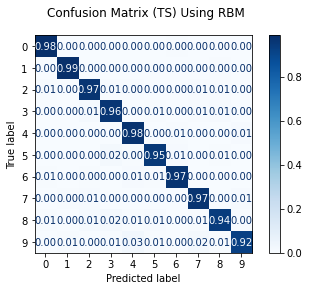

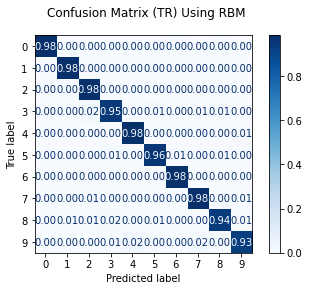

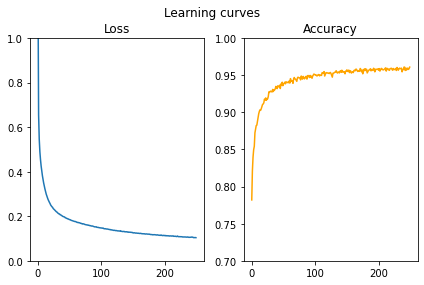

In [7]:
_, hidden_probab_wake_tr = rbm.get_sample_of_hidden(tr_images)
_,hidden_probab_wake_ts = rbm.get_sample_of_hidden(ts_images)

classify(hidden_probab_wake_tr, tr_labels, hidden_probab_wake_ts, ts_labels, "Using RBM")

# Classification using the standard dataset (without the RBM)#

/home/gabriele/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Report MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=250,
              momentum=0.9, n_iter_no_change=200, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97

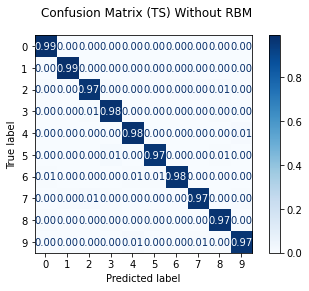

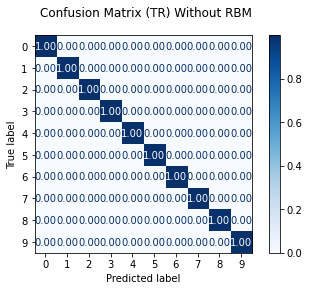

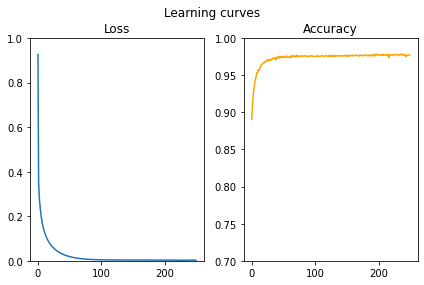

In [8]:
classify(tr_images, tr_labels, ts_images, ts_labels, "Without RBM")